In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

Data Preprocessing 

In [ ]:
def make_list(input):
  final = input[0]
  for i in range(1, len(input)):
    final.extend(input[i])
  return final

def split_series(series, n_past, n_future):

  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  date, notes, counts = list(), list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    date_w, notes_w, counts_w = series[window_start:past_end, 0], make_list(series[window_start:past_end, 1]), int(series[future_end-1, 2])
    date.append(date_w)
    notes.append(notes_w)
    counts.append(counts_w)
  return date, notes, counts

In [ ]:
df = pd.read_csv('task_3_event_prediction.tsv', sep='\t', header=0, low_memory=False, skip_blank_lines=True)
df = df[df['EVENT_TYPE'].notna()]
df['EVENT_DATE'] = pd.to_datetime(df['EVENT_DATE'])
df.sort_values('EVENT_DATE', inplace=True)

In [ ]:
info ={}
for ele in range(len(df)):
  try:
    date = str(df.loc[ele, 'EVENT_DATE'])
    if str(df.loc[ele, 'EVENT_TYPE']) == 'Protests':
        if date in info:
          info[date] += 1
        else:
          info[date] = 1
  except KeyError:
    pass
    
df2 = pd.DataFrame({'EVENT_DATE':info.keys(), 'PROTEST_COUNT':info.values()})
df2['EVENT_DATE'] = pd.to_datetime(df2['EVENT_DATE'])
df2 = df2.sort_values('EVENT_DATE')

In [ ]:
info ={}
for ele in range(len(df)):
  try:
    date = str(df.loc[ele, 'EVENT_DATE'])
    if date in info:
      info[date].append(str(df.loc[ele, 'NOTES']))
    else:
      info[date] = [str(df.loc[ele, 'NOTES'])]
  except KeyError:
    pass

df3 = pd.DataFrame({'EVENT_DATE':info.keys(), 'NOTES':info.values(), 'PROTEST_COUNT':df2['PROTEST_COUNT']})
df3['EVENT_DATE'] = pd.to_datetime(df3['EVENT_DATE'])
df3 = df3.sort_values('EVENT_DATE')
df3 = df3.astype({'EVENT_DATE':str, 'PROTEST_COUNT':int} )


hist is number fo days for historical context

future is how far in future do we predict

encoding_len is max length of sentence embeddings

temp has the final preprocessed data

In [ ]:
hist = 3
future = 3
encoding_len = 200

date, notes, counts = split_series(df3.values, hist, future)
temp = pd.DataFrame({'EVENT_DATE':date, 'NOTES':notes, 'PROTEST_COUNT':counts})

Split data in train and test set

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(temp, test_size=0.2)

Using BERT transformer

In [ ]:
!pip install transformers -q

In [ ]:
from transformers import BertModel, BertTokenizerFast
import torch
import torch.nn as nn
from sklearn.datasets import fetch_20newsgroups
from pprint import  pprint
import re
from collections import Counter
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

Get embeddings in required format

In [ ]:
def get_maxPooled_tensor(input):
  temp_enc = tokenizer.batch_encode_plus(input, padding="max_length", max_length=encoding_len, return_tensors="pt", truncation=True)
  return torch.max(temp_enc.input_ids, 0).values, torch.max(temp_enc.token_type_ids, 0).values, torch.max(temp_enc.attention_mask, 0).values

In [ ]:
def get_tensors(input_df):
  final_input_ids, final_type_ids, final_attn_mask = [], [], []
  for i in range(len(input_df)):
    temp_input_ids, temp_type_ids, temp_attn_mask = get_maxPooled_tensor(input_df.iloc[i]['NOTES'])
    final_input_ids.append(temp_input_ids)
    final_type_ids.append(temp_type_ids)
    final_attn_mask.append(temp_attn_mask)
    
  return torch.stack(final_input_ids), torch.stack(final_type_ids), torch.stack(final_attn_mask)


In [ ]:
train_input_ids, train_type_ids, train_attn_mask = get_tensors(train_df)
test_input_ids, test_type_ids, test_attn_mask = get_tensors(test_df)

In [ ]:
train_input_ids.shape, train_type_ids.shape, train_attn_mask.shape

(torch.Size([1181, 200]), torch.Size([1181, 200]), torch.Size([1181, 200]))

Feature Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_df['SCALED_PROTEST_COUNT'] = scaler.fit_transform(train_df['PROTEST_COUNT'].values.reshape(-1,1))
test_df['SCALED_PROTEST_COUNT'] = scaler.fit_transform(test_df['PROTEST_COUNT'].values.reshape(-1,1))

Resultant data

In [ ]:
train_df

,EVENT_DATE,NOTES,PROTEST_COUNT,SCALED_PROTEST_COUNT
1412,"[2021-11-13, 2021-11-14, 2021-11-15]","[On 13 November 2021, at least 46 Dimasa Natio...",80,-0.792135
537,"[2019-06-22, 2019-06-23, 2019-06-24]","[On 22 June, villagers beat up and tonsured an...",45,-0.890449
101,"[2018-04-12, 2018-04-13, 2018-04-14]","[On 12 April 2018, as part of a larger nationw...",43,-0.896067
535,"[2019-06-20, 2019-06-21, 2019-06-22]","[On June 20, activists of several organisation...",43,-0.896067
1099,"[2021-01-04, 2021-01-05, 2021-01-06]","[On 4 January 2021, Congress MPs from Punjab a...",120,-0.679775
...,...,...,...,...
126,"[2018-05-07, 2018-05-08, 2018-05-09]","[On 7 May 2018, the police found a large quant...",20,-0.960674
103,"[2018-04-14, 2018-04-15, 2018-04-16]",[Unidentified gunmen shot at a police party ne...,27,-0.941011
612,"[2019-09-05, 2019-09-06, 2019-09-07]","[On 5 September, 50-60 relatives of those inju...",57,-0.856742
1370,"[2021-10-02, 2021-10-03, 2021-10-04]","[On 2 October 2021, thousands of farmers of BK...",57,-0.856742


Data loaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


batch_size = 16
# batch_size = 64

def get_dataloader(input_ids, type_ids, attn_mask, y):
    data = TensorDataset(input_ids, type_ids, attn_mask, y)
    sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return dataloader

train_datalaoder = get_dataloader(train_input_ids, train_type_ids, train_attn_mask, torch.tensor(train_df['SCALED_PROTEST_COUNT'].to_numpy()))
test_datalaoder = get_dataloader(test_input_ids, test_type_ids, test_attn_mask, torch.tensor(test_df['SCALED_PROTEST_COUNT'].to_numpy()))

In [ ]:
# Sanity check that the tensors returned by the dataloader are correct

for batch in train_datalaoder:
    input_ids, type_ids, attn_mask, y = batch
    print(input_ids.shape, type_ids.shape, attn_mask.shape, y.shape)
    print(y)
    print(y.dtype)
    break


torch.Size([16, 200]) torch.Size([16, 200]) torch.Size([16, 200]) torch.Size([16])
tensor([-0.8933, -0.8876, -0.8652, -0.6517, -0.8371, -0.8820, -0.9831, -0.9522,
        -0.9579, -0.8034, -0.8118, -0.9045, -0.8006, -0.9129, -0.9522, -0.9270],
       dtype=torch.float64)
torch.float64


Model Class

In [ ]:
class BERTClassifier(nn.Module):
  def __init__(self, transformer, drop_rate):
    super().__init__()
    self.transformer = transformer
    self.regressor = nn.Sequential(
        nn.Dropout(drop_rate),
        nn.Linear(768, 1))
    self.double()

  def forward(self, in_ids, type_ids, attn_mask):
    op = self.transformer(input_ids=in_ids, attention_mask=attn_mask, 
                          token_type_ids=type_ids)
    
    return self.regressor(op["pooler_output"])

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)


fine_tune transformer network or not.

In [ ]:
fine_tune = True
transformer = BertModel.from_pretrained("bert-base-uncased")
model = BERTClassifier(transformer, 0.2).to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The model has 109,483,009 trainable parameters


In [ ]:
if not fine_tune:
  for name, param in model.named_parameters():
    if "pooler" in name or "linear" in name:#or "layer.11" in name or "layer.10" in name or "linear" in name:
      param.requires_grad = True
    else:
      param.requires_grad = False
    print(name, param.shape, param.requires_grad)

  print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
# Training function: Performs forward propagation, backpropagation & optimization.
# We also implement gradient clipping, which prevents the gradients from exploding

def train(model, dataloader, optimizer, criterion, clip=1.0):

    model.train()

    ep_t_loss = 0
    batch_num  = 0
    pred, tgt = [], []
    for ix, batch in tqdm(enumerate(dataloader)):
        batch = tuple(t.to(device) for t in batch)
        input_ids, type_ids, attn_mask, y = batch
        
        optimizer.zero_grad()
        output = model(input_ids, type_ids, attn_mask)
        loss = criterion(output.squeeze(), y)
        loss.backward()

        #gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        ep_t_loss += loss.item()
        batch_num += 1
        pred.extend(output.squeeze().tolist())
        tgt.extend(y.tolist())

    return ep_t_loss/batch_num, metrics.r2_score(tgt, pred)

# Evaluation function: Calculates loss on the validation data.
from sklearn import metrics

def evaluate(model, dataloader, criterion):

    model.eval()

    ep_t_loss = 0
    batch_num  = 0
    pred, tgt = [], []
    for ix, batch in enumerate(dataloader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, type_ids, attn_mask, y = batch

        with torch.no_grad():
            output = model(input_ids, type_ids, attn_mask)
            
            loss = criterion(output.squeeze(), y)

            ep_t_loss += loss.item()
            batch_num += 1
            pred.extend(output.squeeze().tolist())
            tgt.extend(y.tolist())
        
    return ep_t_loss/batch_num, metrics.r2_score(tgt, pred), pred, tgt

In [ ]:
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(), lr = 2e-5)

In [ ]:
best_valid_loss = float('inf')
tot_t_loss, tot_v_loss =[],[]
N_EPOCHS = 10

In [ ]:
import time
from tqdm import tqdm

train_loss_track, test_loss_track, train_r2_track, test_r2_track = [0]*N_EPOCHS, [0]*N_EPOCHS, [0]*N_EPOCHS, [0]*N_EPOCHS

for epoch in tqdm(range(N_EPOCHS)): 

    tr_l, tr_r2= train(model, train_datalaoder, optim, criterion)
    tot_t_loss.append(tr_l)

    te_l, te_r2, pred, tgt = evaluate(model, test_datalaoder, criterion)
    tot_v_loss.append(te_l)
    
    if te_l < best_valid_loss:
        best_valid_loss = te_l
        best_pred, best_tgt = pred, tgt
        torch.save(model.state_dict(), 'model_least_loss.pt')
        print("\nBest Model Saved !!")
    elif epoch % 3 == 0:
        torch.save(model.state_dict(), 'model_checkpoint_'+str(epoch)+'.pt')
        print("\Checkpoint Model Saved !!")
    print("\n")
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Total Loss: {tr_l:.3f} | Train R2: {tr_r2:.3f}')
    print(f'\tTest. Total Loss: {te_l:.3f} | Test R2: {te_r2:.3f}')
    train_loss_track[epoch] = tr_l
    test_loss_track[epoch] = te_l
    train_r2_track[epoch] = tr_r2
    test_r2_track[epoch] = te_r2
    print("_________________________________________________________________")

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:02,  2.57s/it]
2it [00:05,  2.54s/it]
3it [00:07,  2.53s/it]
4it [00:10,  2.53s/it]
5it [00:12,  2.53s/it]
6it [00:15,  2.52s/it]
7it [00:17,  2.52s/it]
8it [00:20,  2.52s/it]
9it [00:22,  2.51s/it]
10it [00:25,  2.51s/it]
11it [00:27,  2.51s/it]
12it [00:30,  2.51s/it]
13it [00:32,  2.51s/it]
14it [00:35,  2.51s/it]
15it [00:37,  2.51s/it]
16it [00:40,  2.51s/it]
17it [00:42,  2.51s/it]
18it [00:45,  2.51s/it]
19it [00:47,  2.51s/it]
20it [00:50,  2.51s/it]
21it [00:52,  2.50s/it]
22it [00:55,  2.51s/it]
23it [00:57,  2.51s/it]
24it [01:00,  2.50s/it]
25it [01:02,  2.50s/it]
26it [01:05,  2.50s/it]
27it [01:07,  2.50s/it]
28it [01:10,  2.50s/it]
29it [01:12,  2.50s/it]
30it [01:15,  2.50s/it]
31it [01:17,  2.50s/it]
32it [01:20,  2.50s/it]
33it [01:22,  2.50s/it]
34it [01:25,  2.50s/it]
35it [01:27,  2.50s/it]
36it [01:30,  2.50s/it]
37it [01:32,  2.50s/it]
38it [01:35,  2.50s/it]
39it [01:37,  2.50s/it]
40it [01:40,  2


Best Model Saved !!


Epoch: 01
	Train Total Loss: 0.086 | Train R2: -2.177
	Test. Total Loss: 0.034 | Test R2: 0.161
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:02,  2.52s/it]
2it [00:05,  2.50s/it]
3it [00:07,  2.50s/it]
4it [00:10,  2.50s/it]
5it [00:12,  2.50s/it]
6it [00:14,  2.50s/it]
7it [00:17,  2.50s/it]
8it [00:19,  2.50s/it]
9it [00:22,  2.50s/it]
10it [00:24,  2.50s/it]
11it [00:27,  2.50s/it]
12it [00:29,  2.50s/it]
13it [00:32,  2.50s/it]
14it [00:34,  2.50s/it]
15it [00:37,  2.50s/it]
16it [00:39,  2.50s/it]
17it [00:42,  2.50s/it]
18it [00:44,  2.50s/it]
19it [00:47,  2.50s/it]
20it [00:49,  2.50s/it]
21it [00:52,  2.50s/it]
22it [00:54,  2.49s/it]
23it [00:57,  2.49s/it]
24it [00:59,  2.49s/it]
25it [01:02,  2.49s/it]
26it [01:04,  2.49s/it]
27it [01:07,  2.49s/it]
28it [01:09,  2.49s/it]
29it [01:12,  2.50s/it]
30it [01:14,  2.50s/it]
31it [01:17,  2.50s/it]
32it [01:19,  2.50s/it]
33it [01:22,  2.49s/it]
34it [01:24,  2.49s/it]
35it [01:27,  2.49s/it]
36it [01:29,  2.49s/it]
37it [01:32,  2.48s/it]
38it [01:34,  2.49s/it]
39it [01:37,  2.49s/it]
40it [01:39,  2.49s/it]
41it [01:42,  2.49s/it]
42it 



Epoch: 02
	Train Total Loss: 0.026 | Train R2: 0.032
	Test. Total Loss: 0.049 | Test R2: -0.239
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:02,  2.48s/it]
2it [00:04,  2.48s/it]
3it [00:07,  2.49s/it]
4it [00:09,  2.49s/it]
5it [00:12,  2.49s/it]
6it [00:14,  2.49s/it]
7it [00:17,  2.49s/it]
8it [00:19,  2.49s/it]
9it [00:22,  2.49s/it]
10it [00:24,  2.49s/it]
11it [00:27,  2.49s/it]
12it [00:29,  2.50s/it]
13it [00:32,  2.49s/it]
14it [00:34,  2.49s/it]
15it [00:37,  2.48s/it]
16it [00:39,  2.49s/it]
17it [00:42,  2.49s/it]
18it [00:44,  2.50s/it]
19it [00:47,  2.50s/it]
20it [00:49,  2.50s/it]
21it [00:52,  2.50s/it]
22it [00:54,  2.50s/it]
23it [00:57,  2.50s/it]
24it [00:59,  2.49s/it]
25it [01:02,  2.49s/it]
26it [01:04,  2.49s/it]
27it [01:07,  2.49s/it]
28it [01:09,  2.49s/it]
29it [01:12,  2.49s/it]
30it [01:14,  2.49s/it]
31it [01:17,  2.49s/it]
32it [01:19,  2.48s/it]
33it [01:22,  2.49s/it]
34it [01:24,  2.49s/it]
35it [01:27,  2.49s/it]
36it [01:29,  2.49s/it]
37it [01:32,  2.49s/it]
38it [01:34,  2.49s/it]
39it [01:37,  2.49s/it]
40it [01:39,  2.49s/it]
41it [01:42,  2.49s/it]
42it 



Epoch: 03
	Train Total Loss: 0.022 | Train R2: 0.191
	Test. Total Loss: 0.039 | Test R2: 0.025
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:02,  2.49s/it]
2it [00:04,  2.49s/it]
3it [00:07,  2.49s/it]
4it [00:09,  2.50s/it]
5it [00:12,  2.50s/it]
6it [00:14,  2.50s/it]
7it [00:17,  2.49s/it]
8it [00:19,  2.49s/it]
9it [00:22,  2.49s/it]
10it [00:24,  2.49s/it]
11it [00:27,  2.49s/it]
12it [00:29,  2.49s/it]
13it [00:32,  2.49s/it]
14it [00:34,  2.49s/it]
15it [00:37,  2.49s/it]
16it [00:39,  2.49s/it]
17it [00:42,  2.49s/it]
18it [00:44,  2.49s/it]
19it [00:47,  2.49s/it]
20it [00:49,  2.49s/it]
21it [00:52,  2.49s/it]
22it [00:54,  2.49s/it]
23it [00:57,  2.49s/it]
24it [00:59,  2.49s/it]
25it [01:02,  2.49s/it]
26it [01:04,  2.49s/it]
27it [01:07,  2.49s/it]
28it [01:09,  2.49s/it]
29it [01:12,  2.49s/it]
30it [01:14,  2.49s/it]
31it [01:17,  2.49s/it]
32it [01:19,  2.49s/it]
33it [01:22,  2.49s/it]
34it [01:24,  2.49s/it]
35it [01:27,  2.49s/it]
36it [01:29,  2.49s/it]
37it [01:32,  2.50s/it]
38it [01:34,  2.50s/it]
39it [01:37,  2.50s/it]
40it [01:39,  2.50s/it]
41it [01:42,  2.50s/it]
42it 


Best Model Saved !!


Epoch: 04
	Train Total Loss: 0.017 | Train R2: 0.385
	Test. Total Loss: 0.033 | Test R2: 0.185
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:02,  2.50s/it]
2it [00:05,  2.50s/it]
3it [00:07,  2.49s/it]
4it [00:09,  2.49s/it]
5it [00:12,  2.49s/it]
6it [00:14,  2.49s/it]
7it [00:17,  2.49s/it]
8it [00:19,  2.49s/it]
9it [00:22,  2.49s/it]
10it [00:24,  2.49s/it]
11it [00:27,  2.49s/it]
12it [00:29,  2.50s/it]
13it [00:32,  2.50s/it]
14it [00:34,  2.50s/it]
15it [00:37,  2.49s/it]
16it [00:39,  2.50s/it]
17it [00:42,  2.50s/it]
18it [00:44,  2.49s/it]
19it [00:47,  2.49s/it]
20it [00:49,  2.49s/it]
21it [00:52,  2.49s/it]
22it [00:54,  2.49s/it]
23it [00:57,  2.49s/it]
24it [00:59,  2.49s/it]
25it [01:02,  2.49s/it]
26it [01:04,  2.49s/it]
27it [01:07,  2.49s/it]
28it [01:09,  2.49s/it]
29it [01:12,  2.49s/it]
30it [01:14,  2.49s/it]
31it [01:17,  2.49s/it]
32it [01:19,  2.49s/it]
33it [01:22,  2.50s/it]
34it [01:24,  2.50s/it]
35it [01:27,  2.50s/it]
36it [01:29,  2.50s/it]
37it [01:32,  2.49s/it]
38it [01:34,  2.49s/it]
39it [01:37,  2.49s/it]
40it [01:39,  2.49s/it]
41it [01:42,  2.49s/it]
42it 



Epoch: 05
	Train Total Loss: 0.015 | Train R2: 0.459
	Test. Total Loss: 0.044 | Test R2: -0.087
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:02,  2.50s/it]
2it [00:04,  2.50s/it]
3it [00:07,  2.50s/it]
4it [00:09,  2.50s/it]
5it [00:12,  2.50s/it]
6it [00:14,  2.49s/it]
7it [00:17,  2.49s/it]
8it [00:19,  2.49s/it]
9it [00:22,  2.49s/it]
10it [00:24,  2.49s/it]
11it [00:27,  2.49s/it]
12it [00:29,  2.49s/it]
13it [00:32,  2.49s/it]
14it [00:34,  2.49s/it]
15it [00:37,  2.50s/it]
16it [00:39,  2.50s/it]
17it [00:42,  2.50s/it]
18it [00:44,  2.50s/it]
19it [00:47,  2.50s/it]
20it [00:49,  2.50s/it]
21it [00:52,  2.49s/it]
22it [00:54,  2.49s/it]
23it [00:57,  2.49s/it]
24it [00:59,  2.49s/it]
25it [01:02,  2.49s/it]
26it [01:04,  2.49s/it]
27it [01:07,  2.49s/it]
28it [01:09,  2.49s/it]
29it [01:12,  2.49s/it]
30it [01:14,  2.49s/it]
31it [01:17,  2.49s/it]
32it [01:19,  2.49s/it]
33it [01:22,  2.49s/it]
34it [01:24,  2.49s/it]
35it [01:27,  2.49s/it]
36it [01:29,  2.49s/it]
37it [01:32,  2.49s/it]
38it [01:34,  2.50s/it]
39it [01:37,  2.49s/it]
40it [01:39,  2.49s/it]
41it [01:42,  2.49s/it]
42it 



Epoch: 06
	Train Total Loss: 0.012 | Train R2: 0.559
	Test. Total Loss: 0.040 | Test R2: 0.055
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:02,  2.50s/it]
2it [00:05,  2.51s/it]
3it [00:07,  2.51s/it]
4it [00:10,  2.52s/it]
5it [00:12,  2.52s/it]
6it [00:15,  2.51s/it]
7it [00:17,  2.50s/it]
8it [00:20,  2.50s/it]
9it [00:22,  2.50s/it]
10it [00:25,  2.49s/it]
11it [00:27,  2.48s/it]
12it [00:29,  2.48s/it]
13it [00:32,  2.49s/it]
14it [00:34,  2.49s/it]
15it [00:37,  2.50s/it]
16it [00:39,  2.49s/it]
17it [00:42,  2.50s/it]
18it [00:44,  2.50s/it]
19it [00:47,  2.50s/it]
20it [00:49,  2.50s/it]
21it [00:52,  2.50s/it]
22it [00:54,  2.50s/it]
23it [00:57,  2.50s/it]
24it [00:59,  2.50s/it]
25it [01:02,  2.49s/it]
26it [01:04,  2.49s/it]
27it [01:07,  2.49s/it]
28it [01:09,  2.49s/it]
29it [01:12,  2.49s/it]
30it [01:14,  2.49s/it]
31it [01:17,  2.49s/it]
32it [01:19,  2.50s/it]
33it [01:22,  2.49s/it]
34it [01:24,  2.50s/it]
35it [01:27,  2.50s/it]
36it [01:29,  2.50s/it]
37it [01:32,  2.49s/it]
38it [01:34,  2.49s/it]
39it [01:37,  2.49s/it]
40it [01:39,  2.49s/it]
41it [01:42,  2.49s/it]
42it 

\Checkpoint Model Saved !!


Epoch: 07
	Train Total Loss: 0.009 | Train R2: 0.659
	Test. Total Loss: 0.059 | Test R2: -0.460
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:02,  2.49s/it]
2it [00:04,  2.49s/it]
3it [00:07,  2.49s/it]
4it [00:09,  2.49s/it]
5it [00:12,  2.49s/it]
6it [00:14,  2.50s/it]
7it [00:17,  2.51s/it]
8it [00:19,  2.50s/it]
9it [00:22,  2.50s/it]
10it [00:25,  2.50s/it]
11it [00:27,  2.50s/it]
12it [00:29,  2.50s/it]
13it [00:32,  2.49s/it]
14it [00:34,  2.49s/it]
15it [00:37,  2.49s/it]
16it [00:39,  2.49s/it]
17it [00:42,  2.49s/it]
18it [00:44,  2.49s/it]
19it [00:47,  2.49s/it]
20it [00:49,  2.49s/it]
21it [00:52,  2.49s/it]
22it [00:54,  2.50s/it]
23it [00:57,  2.50s/it]
24it [00:59,  2.50s/it]
25it [01:02,  2.50s/it]
26it [01:04,  2.50s/it]
27it [01:07,  2.49s/it]
28it [01:09,  2.49s/it]
29it [01:12,  2.49s/it]
30it [01:14,  2.50s/it]
31it [01:17,  2.50s/it]
32it [01:19,  2.50s/it]
33it [01:22,  2.49s/it]
34it [01:24,  2.49s/it]
35it [01:27,  2.49s/it]
36it [01:29,  2.49s/it]
37it [01:32,  2.49s/it]
38it [01:34,  2.49s/it]
39it [01:37,  2.49s/it]
40it [01:39,  2.50s/it]
41it [01:42,  2.50s/it]
42it 


Best Model Saved !!


Epoch: 08
	Train Total Loss: 0.008 | Train R2: 0.691
	Test. Total Loss: 0.031 | Test R2: 0.235
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:02,  2.52s/it]
2it [00:05,  2.50s/it]
3it [00:07,  2.51s/it]
4it [00:10,  2.50s/it]
5it [00:12,  2.50s/it]
6it [00:15,  2.50s/it]
7it [00:17,  2.50s/it]
8it [00:20,  2.50s/it]
9it [00:22,  2.50s/it]
10it [00:25,  2.50s/it]
11it [00:27,  2.50s/it]
12it [00:30,  2.50s/it]
13it [00:32,  2.49s/it]
14it [00:35,  2.50s/it]
15it [00:37,  2.50s/it]
16it [00:39,  2.50s/it]
17it [00:42,  2.49s/it]
18it [00:44,  2.50s/it]
19it [00:47,  2.50s/it]
20it [00:49,  2.50s/it]
21it [00:52,  2.50s/it]
22it [00:54,  2.50s/it]
23it [00:57,  2.49s/it]
24it [00:59,  2.49s/it]
25it [01:02,  2.50s/it]
26it [01:04,  2.50s/it]
27it [01:07,  2.50s/it]
28it [01:09,  2.50s/it]
29it [01:12,  2.49s/it]
30it [01:14,  2.49s/it]
31it [01:17,  2.49s/it]
32it [01:19,  2.49s/it]
33it [01:22,  2.49s/it]
34it [01:24,  2.49s/it]
35it [01:27,  2.50s/it]
36it [01:29,  2.50s/it]
37it [01:32,  2.50s/it]
38it [01:34,  2.50s/it]
39it [01:37,  2.51s/it]
40it [01:39,  2.50s/it]
41it [01:42,  2.50s/it]
42it 



Epoch: 09
	Train Total Loss: 0.007 | Train R2: 0.743
	Test. Total Loss: 0.034 | Test R2: 0.174
_________________________________________________________________



0it [00:00, ?it/s]
1it [00:02,  2.49s/it]
2it [00:04,  2.49s/it]
3it [00:07,  2.49s/it]
4it [00:09,  2.49s/it]
5it [00:12,  2.49s/it]
6it [00:14,  2.49s/it]
7it [00:17,  2.49s/it]
8it [00:19,  2.50s/it]
9it [00:22,  2.50s/it]
10it [00:24,  2.50s/it]
11it [00:27,  2.49s/it]
12it [00:29,  2.49s/it]
13it [00:32,  2.49s/it]
14it [00:34,  2.49s/it]
15it [00:37,  2.49s/it]
16it [00:39,  2.50s/it]
17it [00:42,  2.50s/it]
18it [00:44,  2.50s/it]
19it [00:47,  2.50s/it]
20it [00:49,  2.50s/it]
21it [00:52,  2.50s/it]
22it [00:54,  2.50s/it]
23it [00:57,  2.49s/it]
24it [00:59,  2.49s/it]
25it [01:02,  2.49s/it]
26it [01:04,  2.49s/it]
27it [01:07,  2.50s/it]
28it [01:09,  2.49s/it]
29it [01:12,  2.49s/it]
30it [01:14,  2.50s/it]
31it [01:17,  2.50s/it]
32it [01:19,  2.50s/it]
33it [01:22,  2.50s/it]
34it [01:24,  2.50s/it]
35it [01:27,  2.50s/it]
36it [01:29,  2.50s/it]
37it [01:32,  2.50s/it]
38it [01:34,  2.50s/it]
39it [01:37,  2.49s/it]
40it [01:39,  2.49s/it]
41it [01:42,  2.50s/it]
42it 

\Checkpoint Model Saved !!


Epoch: 10
	Train Total Loss: 0.007 | Train R2: 0.752
	Test. Total Loss: 0.038 | Test R2: 0.061
_________________________________________________________________


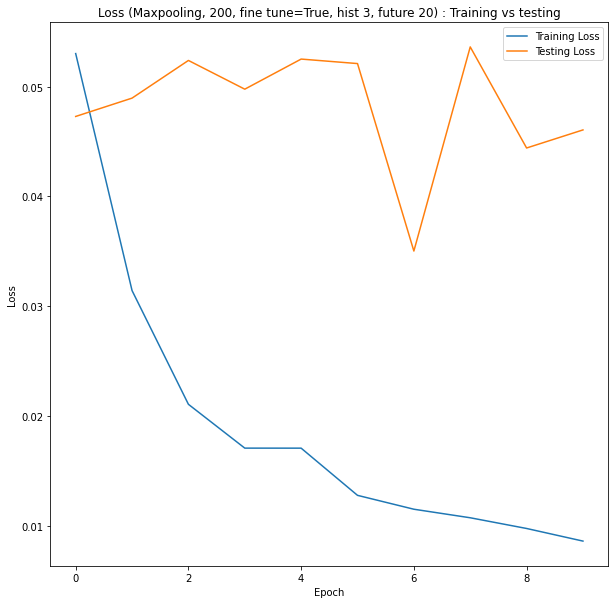

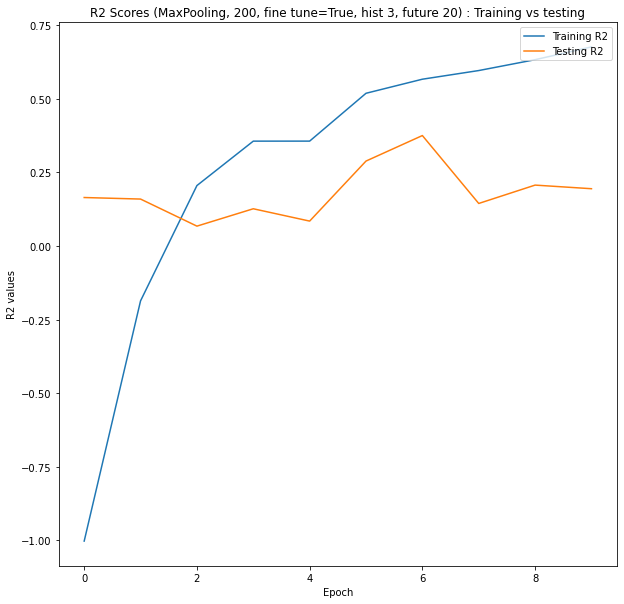

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(train_loss_track)
plt.plot(test_loss_track)
plt.title('Loss (Maxpooling, 200, fine tune=True, hist 3, future 3) : Training vs testing')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(train_r2_track)
plt.plot(test_r2_track)
plt.title('R2 Scores (MaxPooling, 200, fine tune=True, hist 3, future 3) : Training vs testing')
plt.ylabel('R2 values')
plt.xlabel('Epoch')
plt.legend(['Training R2', 'Testing R2'], loc='upper right')
plt.show()